# Nov 24, 2024: group align estimates per animal

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob
from numba import jit
import arviz as az
import random

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from munkres import Munkres

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [3]:
args.type = 'spatial' #'spatial'
args.roi_size = '225' #225
args.maintain_symmetry = True #True
args.brain_div = 'whl' #'whl'
args.num_rois = 162 #162

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson-corr'
args.THRESHOLDING = f'positive'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi_results_v2'
ROI_path = f'{BASE_path}/{PARC_DESC}'
TS_path = f'{ROI_path}/runwise_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
args.dc, args.sbm = False, 'h'

args.nested = True if args.sbm in ['h'] else False

args.force_niter = 40000
args.num_draws = int((1/2) * args.force_niter)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['m', 'a'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [6]:
gfile = sorted(glob.glob(f'{GRAPH_path}/*', recursive=True))[0]
g = gt.load_graph(gfile)
g

<Graph object, undirected, with 162 vertices and 2608 edges, 1 internal edge property, at 0x7f98145dffa0>

In [ ]:
# indiv level estimates
indiv_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes/{SBM}_desc-df.pkl'))
indests_df = []
for indiv_file in tqdm(indiv_files):
    with open(indiv_file, 'rb') as f:
        df = pickle.load(f)
    # sub = [s for s in indiv_file.split('/') if 'sub-' in s][0].split('-')[-1]
    # df['sub'] = [sub] * len(df)
    # df['sbm'] = [SBM] * len(df)
    indests_df += [df]
indests_df = pd.concat(indests_df).reset_index(drop=True)
indests_df

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
indests_df.iloc[15]

mode_id                                                    2
pi         [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...
omega                                                  0.002
sub                                                    SLC08
sbm                                                   sbm--a
Name: 15, dtype: object

In [ ]:
# CHECK IF MODES PER ANIMAL ARE ALIGNED, 
# THEN WE CAN ALIGN THEM AT THE GROUP LEVEL

In [ ]:
def get_membership_matrix(args, df, col='pi'):
    num_modes = len(df)
    num_comms = np.max(df[col].apply(lambda pi: pi.shape[-1]))
    num_rois = df.iloc[0][col].shape[0]
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix

    for idx_mode in range(num_modes):
        pi = df.iloc[idx_mode][col]
        M[:, idx_mode, :pi.shape[-1]] = pi
    return M

In [ ]:
soft_df = []
for sub, group in indests_df.groupby('sub'):
    M = get_membership_matrix(args, group)
    omegas = group['omega'].to_list()
    X = np.average(M, axis=1, weights=omegas)
    soft_df += [pd.DataFrame(dict(
        sub=[sub],
        soft_comm=[X],
    ))]
soft_df = pd.concat(soft_df).reset_index(drop=True)
soft_df

,sub,soft_comm
0,SLC01,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0208, 0.0,..."
1,SLC02,"[[1.0, 0.0, 0.0, 0.0], [0.99995, 0.0, 0.0, 4.9..."
2,SLC03,"[[0.0, 0.0, 0.9997500000000001, 0.000100000000..."
3,SLC04,"[[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [..."
4,SLC05,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."
5,SLC06,"[[0.0, 0.0, 0.0, 0.8463999999999999, 0.0718, 0..."
6,SLC07,"[[0.0, 0.0, 1.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0...."
7,SLC08,"[[1.0, 0.0, 0.0, 0.0], [0.999, 0.0, 0.001, 0.0..."
8,SLC09,"[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ..."
9,SLC10,"[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [..."


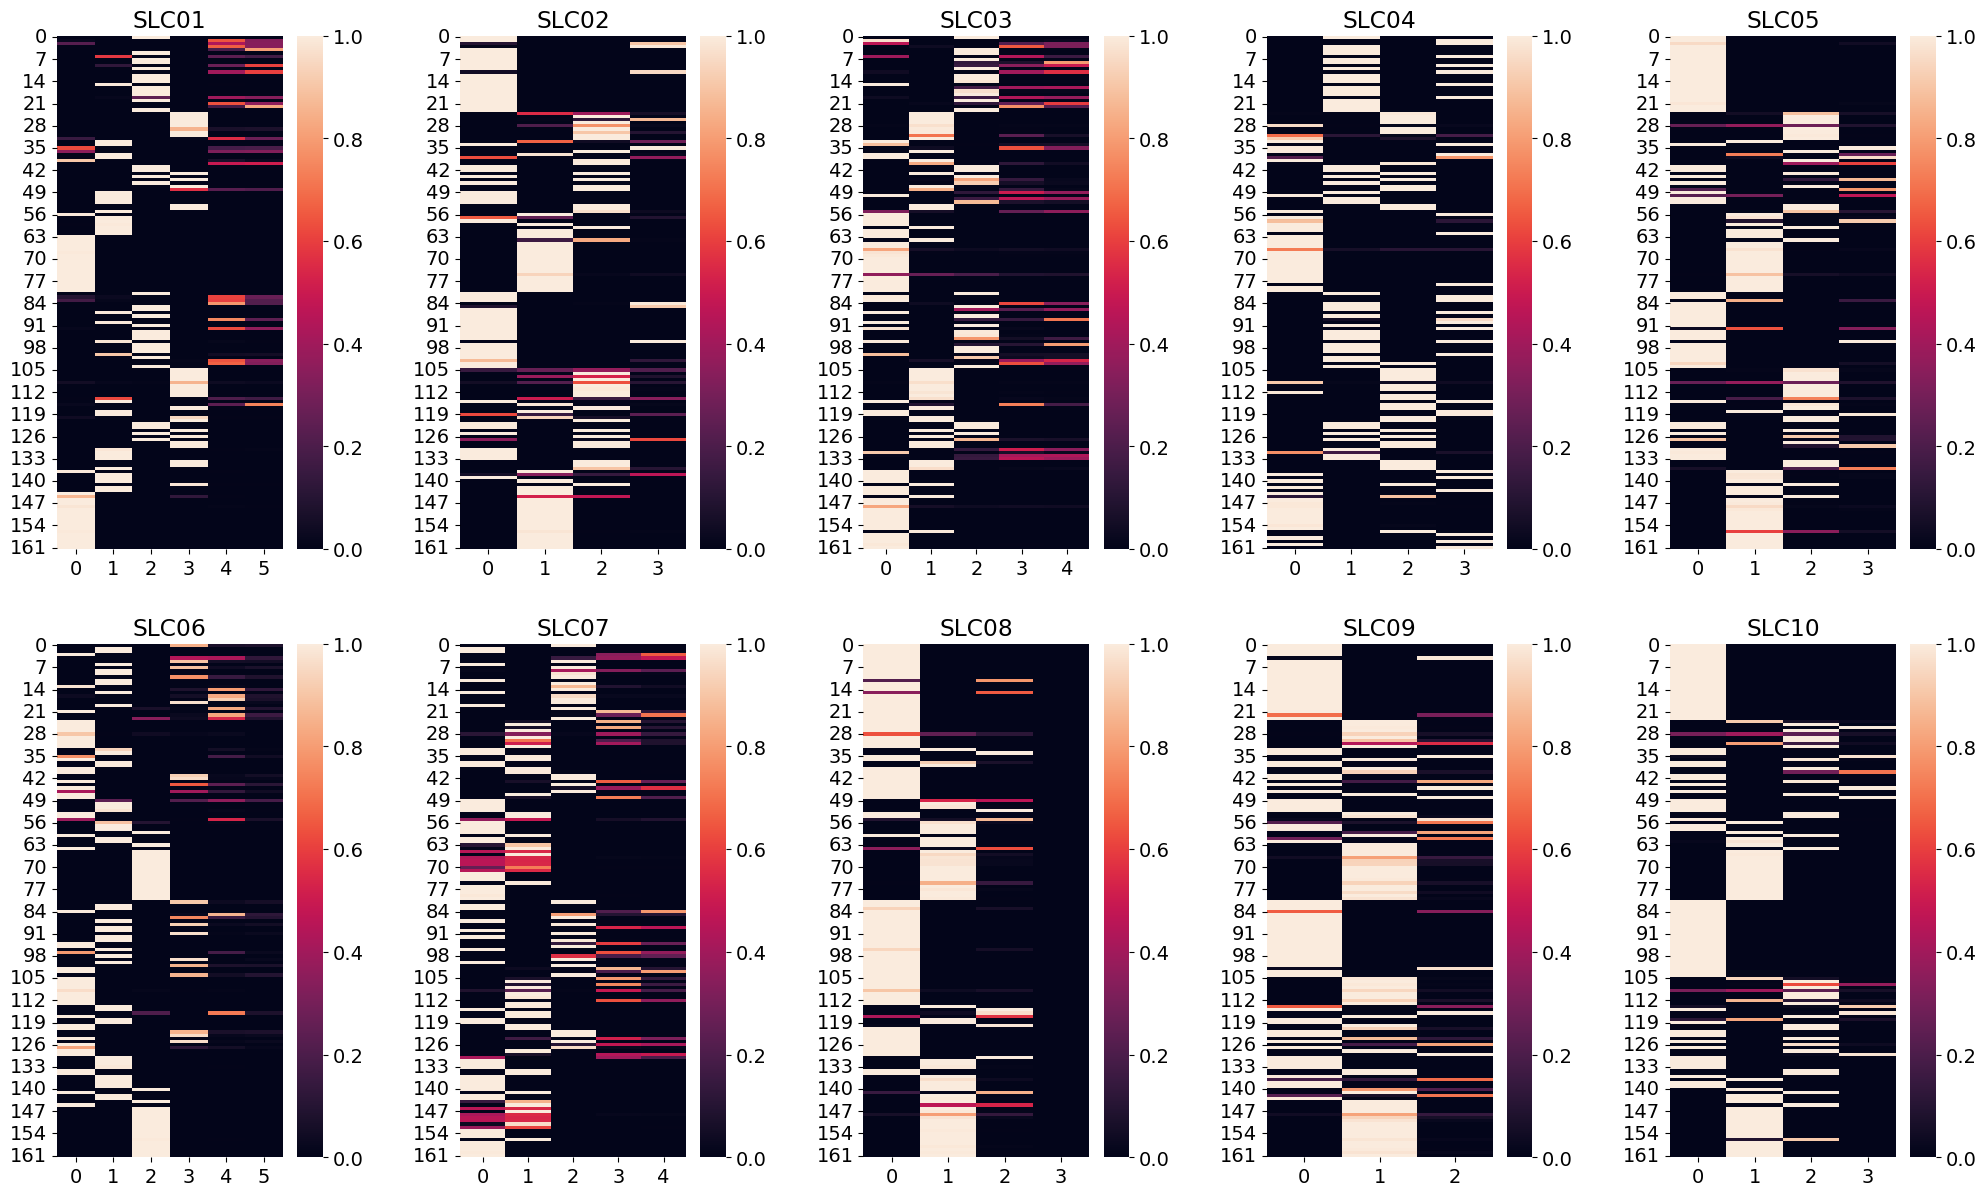

In [ ]:
ncols = 5
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 6*nrows))
fig.tight_layout(h_pad=3, w_pad=3)
for idx, row in soft_df.iterrows():
    r, c = idx // ncols, idx % ncols
    ax = axs[r, c] if nrows > 1 else axs[c]
    sns.heatmap(row['soft_comm'], ax=ax)
    ax.set(title=f'{row["sub"]}')

In [ ]:
# YES, MODES PER ANIMAL ALIGN WELL.
# WE CAN SEE THIS THROUGH THE SHAPRNESS OF SOFT_COMMS: sharp soft_comms means all modes align well, hence they average to 1. 

In [ ]:
# GROUP ALIGN

---
sample partitions from each mode, align them, recompute marginals: stochastic solution

In [ ]:
def sample_partitions(args, indests_df):
    all_bs_df = []
    for idx, row in tqdm(indests_df.iterrows()):
        bs = random.sample(
            list(row['mode'].get_partitions().values()), 
            row['num_samples']
        )
        mode_ids = [idx]*len(bs)
        df = pd.DataFrame(dict(
            mode_id=mode_ids,
            b=bs,
        ))
        all_bs_df += [df]
        # all_bs += [
        #   row['mode'].sample_partition(MLE=True) 
        #   for _ in range(row['num_samples'])
        # ]
    all_bs_df = pd.concat(all_bs_df).reset_index(drop=True)
    return all_bs_df

def sample_nested_partitions(args, indests_df):
    all_bs_df = []
    for idx, row in tqdm(indests_df.iterrows()):
        bs = random.sample(
            list(row['mode'].get_nested_partitions().values()), 
            row['num_samples']
        )
        bs = [gt.nested_partition_clear_null(b) for b in bs]
        mode_ids = [idx]*len(bs)
        df = pd.DataFrame(dict(
            mode_id=mode_ids,
            b=bs,
        ))
        all_bs_df += [df]
        # all_bs += [
        #   row['mode'].sample_partition(MLE=True) 
        #   for _ in range(row['num_samples'])
        # ]
    all_bs_df = pd.concat(all_bs_df).reset_index(drop=True)
    return all_bs_df

In [ ]:
# sample partitions per mode
args.total_samples = 1000
indests_df['num_samples'] = indests_df['omega'].apply(lambda x: np.round(x * args.total_samples).astype(int) if x > 0.01 else 1)
if args.sbm in ['m', 'a', 'd']:
    all_bs_df = sample_partitions(args, indests_df)
if args.sbm in ['h']:
    all_bs_df = sample_nested_partitions(args, indests_df)

0it [00:00, ?it/s]


KeyError: 'mode'

In [ ]:
# align all samples iteratively until the labels converge
pmode = gt.PartitionModeState(all_bs_df['b'], relabel=True, nested=args.nested, converge=False)
ent_diff = -np.inf
while ent_diff < 1e-10:
    ed = pmode.replace_partitions()
    print(ed)
    if np.isclose(ed, ent_diff, rtol=1e-10):
        break
    ent_diff = ed

-36559.03097218852
-5560.650856076005
-2736.6661071515437
-576.1176979069495
-339.6137980196075
-488.80901896053064
-369.1347070705092
-10.28739968782574
-1.2010565045936232
-1.5634509509254713e-07
-1.5634509509254713e-07


In [ ]:
if args.sbm in ['m', 'a', 'd']:
    bs = pmode.get_partitions()
if args.sbm in ['h']:
    bs = pmode.get_nested_partitions()
bs = {k:v for k, v in sorted(bs.items())}
all_bs_df['b_aligned'] = list(bs.values())

In [ ]:
all_bs_df

,mode_id,b,b_aligned
0,0,"[[5, 8, 13, 0, 15, 15, 0, 0, 4, 0, 8, 0, 0, 15...","[[0, 1, 2, 3, 4, 4, 3, 3, 5, 3, 1, 3, 3, 4, 4,..."
1,0,"[[5, 8, 13, 0, 15, 0, 8, 0, 4, 0, 15, 0, 8, 15...","[[0, 1, 2, 3, 4, 3, 1, 3, 5, 3, 4, 3, 1, 4, 4,..."
2,0,"[[5, 8, 13, 0, 15, 15, 0, 0, 4, 0, 8, 0, 0, 15...","[[0, 1, 2, 3, 4, 4, 3, 3, 5, 3, 1, 3, 3, 4, 4,..."
3,0,"[[5, 8, 13, 0, 15, 15, 8, 0, 4, 0, 15, 0, 0, 1...","[[0, 1, 2, 3, 4, 4, 1, 3, 5, 3, 4, 3, 3, 4, 4,..."
4,0,"[[12, 8, 13, 0, 15, 0, 8, 0, 4, 0, 15, 0, 8, 1...","[[8, 1, 2, 3, 4, 3, 1, 3, 5, 3, 4, 3, 1, 4, 4,..."
...,...,...,...
10001,48,"[[23, 9, 9, 20, 5, 7, 1, 7, 7, 7, 20, 6, 1, 5,...","[[0, 2, 2, 4, 10, 23, 3, 23, 23, 23, 4, 17, 3,..."
10002,48,"[[23, 9, 9, 20, 5, 7, 1, 7, 7, 7, 20, 6, 20, 7...","[[0, 2, 2, 3, 10, 23, 1, 23, 23, 23, 3, 17, 3,..."
10003,48,"[[23, 9, 9, 20, 5, 7, 1, 5, 7, 7, 20, 6, 20, 5...","[[0, 2, 2, 3, 10, 23, 1, 10, 23, 23, 3, 17, 3,..."
10004,48,"[[3, 9, 9, 20, 5, 7, 1, 7, 7, 7, 20, 6, 1, 5, ...","[[8, 2, 2, 4, 10, 23, 3, 23, 23, 23, 4, 17, 3,..."


In [ ]:
def get_pi_matrix(args, mrgnls):
    num_comms = np.max([len(mrgnl) for mrgnl in mrgnls])
    pi = np.zeros((len(mrgnls), num_comms))

    for idx_node, mrgnl in enumerate(mrgnls):
        mrgnl = np.array(mrgnl)
        pi[idx_node, np.where(mrgnl)[0]] = mrgnl[mrgnl > 0]

    pi = pi / np.expand_dims(pi.sum(axis=-1), axis=-1)
    return pi # marginals matrix

In [ ]:
if args.sbm in ['m', 'a', 'd']:
    pis_df = []
    for key, group in tqdm(all_bs_df.groupby(by='mode_id')):
        pm = gt.PartitionModeState(bs=group['b_aligned'], relabel=False, nested=args.nested, converge=False)
        mrgnls = pm.get_marginal(g)
        pi = get_pi_matrix(args, mrgnls)
        df = pd.DataFrame(dict(
            mode_id=[key],
            mode=[pm],
            pi=[pi],
        ))
        pis_df += [df]
        # break
    pis_df = pd.concat(pis_df).reset_index(drop=True)

In [ ]:
def nested_partitions(g, b):
    b = gt.nested_partition_clear_null(b)
    state = gt.NestedBlockState(g, bs=[g.new_vp("int", vals=b[0])] + b[1:])
    state = state.copy(bs=b)
    bs = []
    for l, bl in enumerate(b):
        bl_ = np.array(state.project_level(l).get_state().a)
        bs.append(bl_)
        if len(np.unique(bl_)) == 1: break
    return bs

def project_partitions_on_graph(args, all_bs, max_level=-1):
    proj_bs = []
    for bs in (all_bs):
        proj_bs += [nested_partitions(g, bs)]
    max_level = np.max([len(bs) for bs in proj_bs]) if max_level == -1 else max_level
    level_bs = [[] for _ in range(max_level)]
    for bs in proj_bs:
        for level in range(max_level):
            level_bs[level] += [bs[level] if len(bs) > level else [0]*len(bs[0])]
    return level_bs, max_level

def get_nested_pi_matrices(args, level_bs, g, dct):
    for level, bs in enumerate(level_bs):
        pm = gt.PartitionModeState(bs=bs, relabel=False, nested=False, converge=False)
        mrgnls = pm.get_marginal(g)
        pi = get_pi_matrix(args, mrgnls)
        dct[f'mode_{level}'] = [pm]
        dct[f'pi_{level}'] = [pi]
    return dct

In [ ]:
if args.sbm in ['h']:
    pis_df = []
    for key, group in tqdm(all_bs_df.groupby(by='mode_id')):
        level_bs, max_level = project_partitions_on_graph(args, group['b_aligned'])
        dct = {f'mode_id':[key]}
        df = pd.DataFrame(get_nested_pi_matrices(args, level_bs, g, dct))
        pis_df += [df]
        # break
    pis_df = pd.concat(pis_df).reset_index(drop=True)

100%|██████████| 50/50 [39:32<00:00, 47.44s/it]  


In [ ]:
indests_df = indests_df.merge(pis_df, on='mode_id', how='inner', suffixes=['', '_aligned'])
indests_df

,sub,sbm,mode_id,mode,pi,omega,sigma,num_samples,mode_0,pi_0,...,mode_4,pi_4,mode_5,pi_5,mode_6,pi_6,mode_7,pi_7,mode_8,pi_8
0,SLC01,sbm-nd-h,0,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.9897273804820229,...",0.607440,0.039543,607,<graph_tool.inference.partition_modes.Partitio...,"[[0.9901153212520593, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,<graph_tool.inference.partition_modes.Partitio...,"[[0.9983525535420099, 0.0016474464579901153], ...",<graph_tool.inference.partition_modes.Partitio...,"[[0.9983525535420099, 0.0016474464579901153], ...",<graph_tool.inference.partition_modes.Partitio...,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN
1,SLC01,sbm-nd-h,1,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.983162100456621, ...",0.280320,0.066587,280,<graph_tool.inference.partition_modes.Partitio...,"[[0.9892857142857143, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,<graph_tool.inference.partition_modes.Partitio...,"[[0.9964285714285714, 0.0035714285714285713], ...",<graph_tool.inference.partition_modes.Partitio...,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,NaN,NaN
2,SLC01,sbm-nd-h,2,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.9985744832501782,...",0.112240,0.076680,112,<graph_tool.inference.partition_modes.Partitio...,"[[0.16964285714285715, 0.0, 0.0, 0.0, 0.0, 0.0...",...,<graph_tool.inference.partition_modes.Partitio...,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SLC02,sbm-nd-h,0,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.9908140639847957, 0.0, 0.0,...",0.505160,0.069195,505,<graph_tool.inference.partition_modes.Partitio...,"[[0.9901153212520593, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,<graph_tool.inference.partition_modes.Partitio...,"[[0.9983525535420099, 0.0016474464579901153], ...",<graph_tool.inference.partition_modes.Partitio...,"[[0.9983525535420099, 0.0016474464579901153], ...",<graph_tool.inference.partition_modes.Partitio...,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN
4,SLC02,sbm-nd-h,1,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.97117202268431, 0.0, 0.0, 0...",0.338587,0.067681,339,<graph_tool.inference.partition_modes.Partitio...,"[[0.9892857142857143, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,<graph_tool.inference.partition_modes.Partitio...,"[[0.9964285714285714, 0.0035714285714285713], ...",<graph_tool.inference.partition_modes.Partitio...,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,NaN,NaN
5,SLC02,sbm-nd-h,2,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.9759344598054276, 0.0, 0.0,...",0.156253,0.095400,156,<graph_tool.inference.partition_modes.Partitio...,"[[0.16964285714285715, 0.0, 0.0, 0.0, 0.0, 0.0...",...,<graph_tool.inference.partition_modes.Partitio...,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,SLC03,sbm-nd-h,0,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.647204354280...",0.161628,0.100658,162,<graph_tool.inference.partition_modes.Partitio...,"[[0.9901153212520593, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,<graph_tool.inference.partition_modes.Partitio...,"[[0.9983525535420099, 0.0016474464579901153], ...",<graph_tool.inference.partition_modes.Partitio...,"[[0.9983525535420099, 0.0016474464579901153], ...",<graph_tool.inference.partition_modes.Partitio...,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",NaN,NaN,NaN,NaN
7,SLC03,sbm-nd-h,1,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.516726711271...",0.155390,0.097251,155,<graph_tool.inference.partition_modes.Partitio...,"[[0.9892857142857143, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,<graph_tool.inference.partition_modes.Partitio...,"[[0.9964285714285714, 0.0035714285714285713], ...",<graph_tool.inference.partition_modes.Partitio...,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0

In [ ]:
if args.sbm in ['m', 'a', 'd']:
    soft_aligned_df = []
    for sub, group in indests_df.groupby('sub'):
        M = get_membership_matrix(args, group, col=f'pi_aligned')
        omegas = group['omega'].to_list()
        X = np.average(M, axis=1, weights=omegas)
        soft_aligned_df += [pd.DataFrame(dict(
            sub=[sub],
            soft_comm=[X],
        ))]
    soft_aligned_df = pd.concat(soft_aligned_df).reset_index(drop=True)
    display(soft_aligned_df)

if args.sbm in ['h']:
    level = 0
    soft_aligned_df = []
    for sub, group in indests_df.groupby('sub'):
        M = get_membership_matrix(args, group, col=f'pi_{level}')
        omegas = group['omega'].to_list()
        X = np.average(M, axis=1, weights=omegas)
        soft_aligned_df += [pd.DataFrame(dict(
            sub=[sub],
            soft_comm=[X],
        ))]
    soft_aligned_df = pd.concat(soft_aligned_df).reset_index(drop=True)
    display(soft_aligned_df)

,sub,soft_comm
0,SLC01,"[[0.8977929364556366, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,SLC02,"[[0.8616335531836663, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,SLC03,"[[0.7347218143727945, 0.0, 0.01904950922275958..."
3,SLC04,"[[0.9459125043909121, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,SLC05,"[[0.8130407774443612, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,SLC06,"[[0.8973256100813988, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,SLC07,"[[0.916710109513164, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,SLC08,"[[0.8483587803360707, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,SLC09,"[[0.8244173424603205, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,SLC10,"[[0.7989304771524457, 0.0, 0.01264977847769932..."


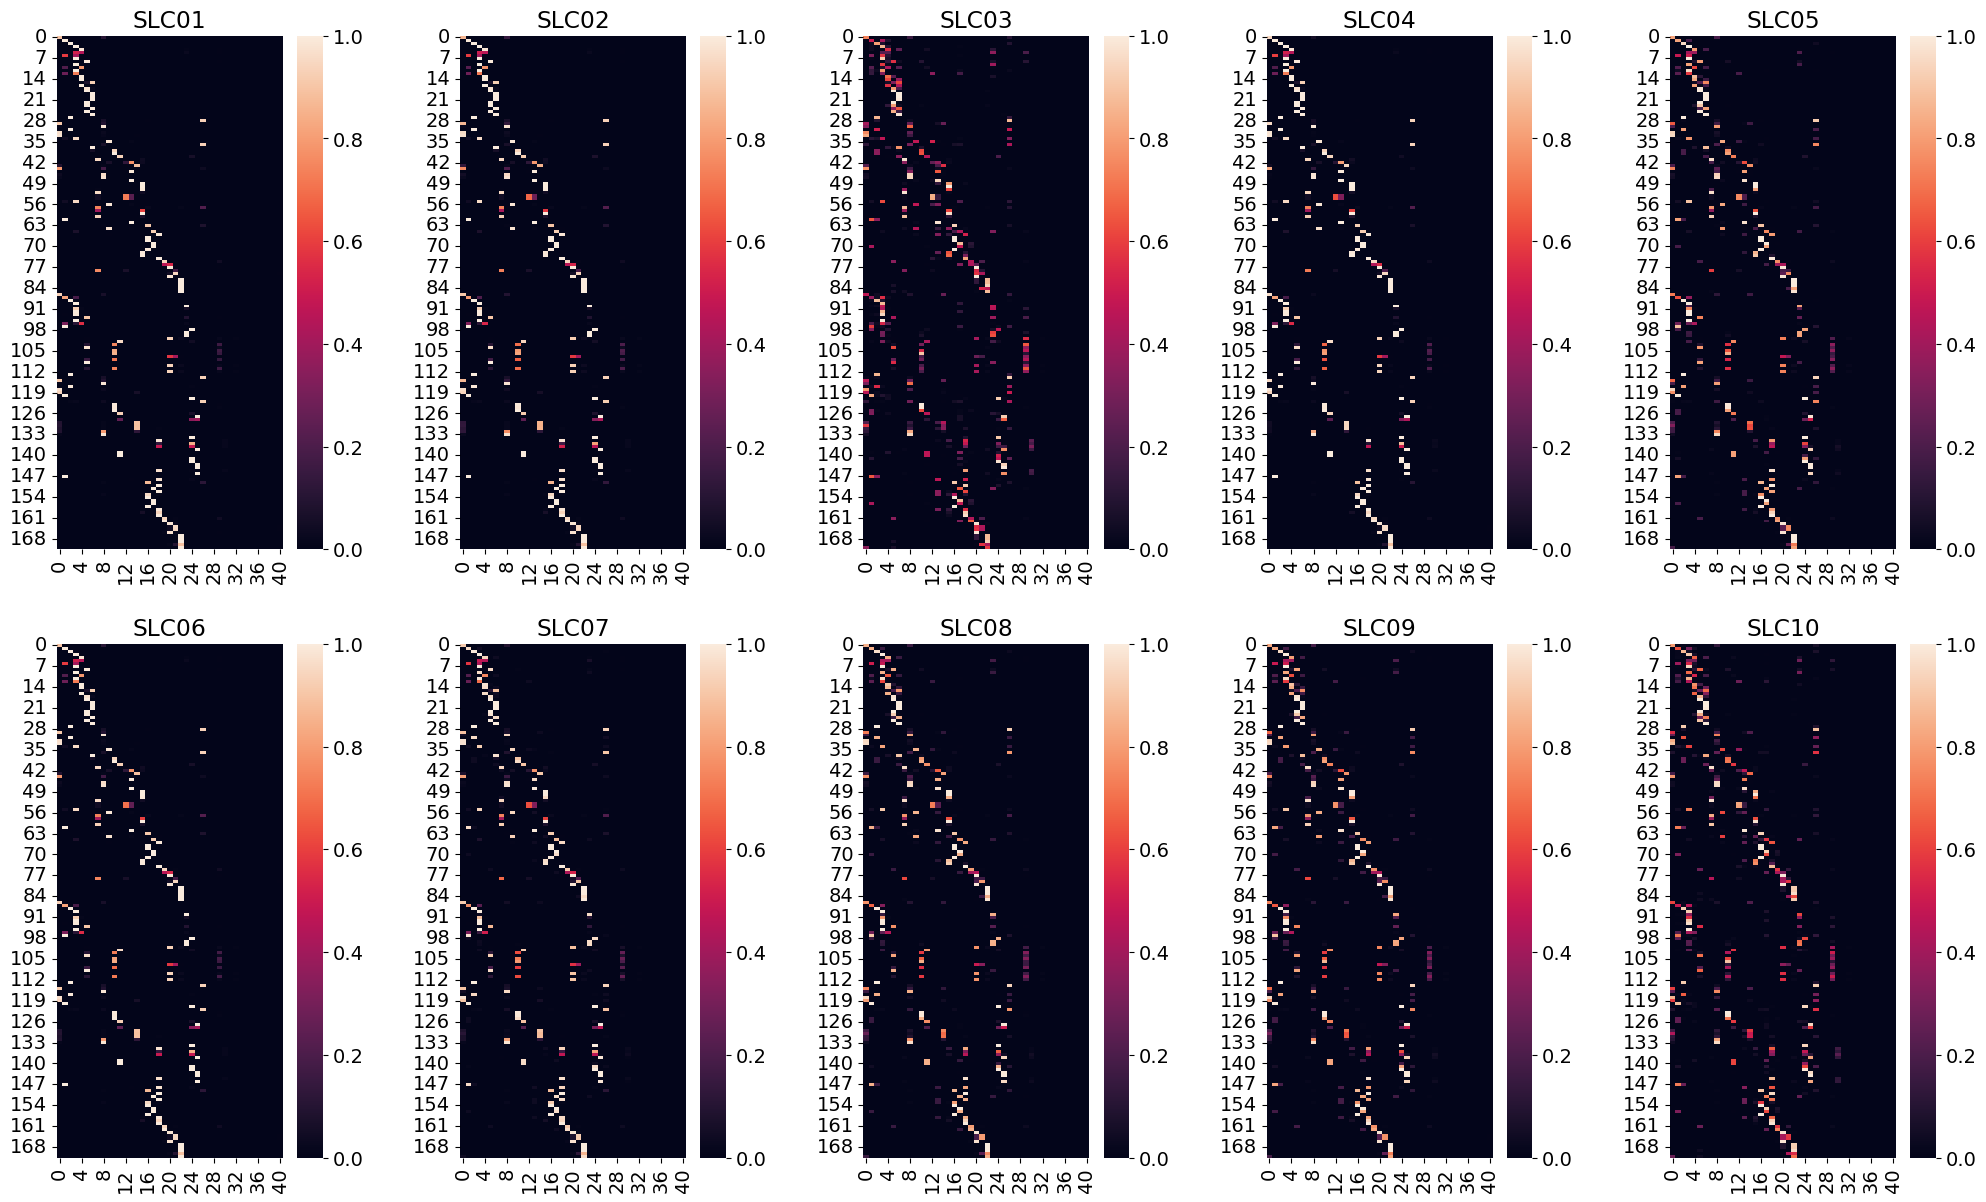

In [ ]:
ncols = 5
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 6*nrows))
fig.tight_layout(h_pad=3, w_pad=3)
for idx, row in soft_aligned_df.iterrows():
    r, c = idx // ncols, idx % ncols
    ax = axs[r, c] if nrows > 1 else axs[c]
    sns.heatmap(row['soft_comm'], ax=ax)
    ax.set(title=f'{row["sub"]}')

[Text(0.5, 1.0, 'group'),
 Text(0.5, 31.722222222222207, 'comm'),
 Text(15.72222222222222, 0.5, 'roi')]

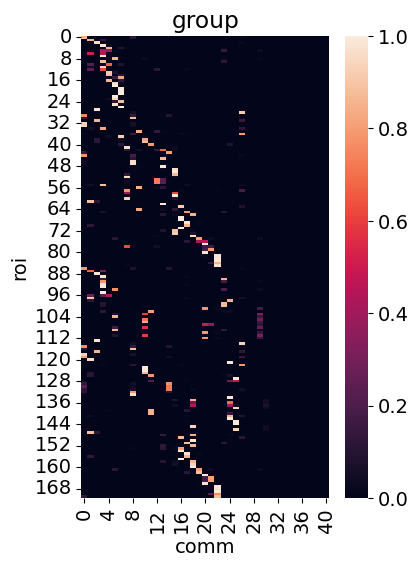

In [ ]:
SCsA = get_membership_matrix(args, soft_aligned_df, col='soft_comm') # soft comms aligned
group_soft_comm = np.mean(SCsA, axis=1)

fig, axs = plt.subplots(1, 1, figsize=(4, 6))
ax = axs
sns.heatmap(group_soft_comm, ax=ax)
ax.set(title=f'group', xlabel=f'comm', ylabel=f'roi')

---

In [ ]:
# SAVE THE ALIGNED MODES AND MARGINALS

In [ ]:
if args.sbm in ['m', 'a', 'd']:
    for sub, group in indests_df.groupby('sub'):
        out_folder = f'{ESTIM_path}/individual/sub-{sub}/partition-modes-group-aligned/{SBM}'
        os.system(f'mkdir -p {out_folder}')

        cols = ['sub', 'sbm', 'mode_aligned', 'omega']
        with open(f'{out_folder}/desc-modes.pkl', 'wb') as f:
            pickle.dump(group[cols], f)
        
        with open(f'{out_folder}/desc-mem-mats.pkl', 'wb') as f:
            pickle.dump(group[['sub', 'sbm', 'pi_aligned', 'omega']], f)
        
        # break

In [ ]:
if args.sbm in ['h']:
    for sub, group in indests_df.groupby('sub'):
        out_folder = f'{ESTIM_path}/individual/sub-{sub}/partition-modes-group-aligned/{SBM}'
        os.system(f'mkdir -p {out_folder}')

        cols = ['sub', 'sbm'] +[col for col in list(group.columns) if 'mode_' in col if 'mode_id' not in col] + ['omega']
        with open(f'{out_folder}/desc-modes.pkl', 'wb') as f:
            pickle.dump(group[cols], f)

        cols = ['sub', 'sbm'] +[col for col in list(group.columns) if 'pi_' in col if 'mode_id' not in col] + ['omega']
        with open(f'{out_folder}/desc-mem-mats.pkl', 'wb') as f:
            pickle.dump(group[cols], f)

        # break

---
align the membership matrices using Hungarian algorithm: deterministic solution